<a href="https://colab.research.google.com/github/Mc4minta/AIB5-PcapAttackClassifier/blob/main/EvaluateModel_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Full Step for evaluation (my model)
- list pcap zip
  - in `/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForBaseline`
- unzip each zip
- iterate through each attack
- iterate to each attack pcap files
- convert to FlowCSV
- process packet map
- preprocess_df
- load model
- predict
- combined label with packet_index
- convert flow-label-index to packetindex-label
- list of predicted label from high to low (final_df)

## final_df format:

| pcap label     | packet label   | ranked_label                    |
| -------------- | -------------- | ------------------------------- |
| FTP-Bruteforce | FTP-Bruteforce | [FTP-Bruteforce,SSH-Bruteforce] |
| Benign         | Benign         | [Benign]                        |

## Evaluate by comparing:
- pcap label and label
- y_test = pcap label
- y_pred = label

## label_rank
- is for tie breaker with baseline just in case

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
# list pcap zip
import os
pcap_zip_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForBaseline/'
files = os.listdir(pcap_zip_dir)
for file in files:
  print(file)

DoS.zip
DDoS.zip
PortScan.zip
Benign.zip
DoS-HTTP-Flood.zip
Benign2.zip
DoS-overall.zip
DoS-Layer3and4.zip
FTP-Bruteforce.zip
SSH-Bruteforce.zip
DoS-Slow-Rate.zip


In [3]:
# list flow zip
import os
pcap_zip_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForbaseline_csv/'
files = os.listdir(pcap_zip_dir)
for file in files:
  print(file)

DoS_csv.zip
DDoS_csv.zip
PortScan_csv.zip
Benign_csv.zip
Benign2_csv.zip
DoS-HTTP-Flood_csv.zip
DoS-Layer3and4_csv.zip
DoS-overall_csv.zip
FTP-Bruteforce_csv.zip
SSH-Bruteforce_csv.zip
DoS-SlowRate_csv.zip


In [4]:
# list each attack folder without '.zip' and append to attacks[]
pcap_zip_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForBaseline/'
files = os.listdir(pcap_zip_dir)
attacks = []
for file in files:
  attacks.append(file[:-4])
for attack in attacks:
  print(attack)

DoS
DDoS
PortScan
Benign
DoS-HTTP-Flood
DoS-SlowRate
Benign2
DoS-overall
DoS-Layer3and4
FTP-Bruteforce
SSH-Bruteforce


In [6]:
attacks

['DoS',
 'DDoS',
 'PortScan',
 'Benign',
 'DoS-HTTP-Flood',
 'DoS-SlowRate',
 'Benign2',
 'DoS-overall',
 'DoS-Layer3and4',
 'FTP-Bruteforce',
 'SSH-Bruteforce']

In [7]:
attacks = [
  # 'DoS',
  # 'DDoS',
  # 'PortScan',
  # 'Benign',
  # 'DoS-HTTP-Flood',
  'DoS-SlowRate',
  # 'Benign2',
  # 'DoS-overall',
  # 'DoS-Layer3and4',
  'FTP-Bruteforce',
  'SSH-Bruteforce']

In [8]:
# define function to unzip(attack.zip)
import zipfile

def unzip_attack_zip(attack):
  pcap_zip_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForBaseline/'
  if(attack[-4:]=='.zip'):
    zip_file_name = attack
  else:
    zip_file_name = attack + '.zip'
  zip_file_path = os.path.join(pcap_zip_dir, zip_file_name)
  destination_directory = '/content/'
  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(destination_directory)
    print(f"'{zip_file_name}' unzipped to '{destination_directory}'.")
  except Exception as e:
      print(f"Error : {e}")

# unzip_attack_zip('DDoS')

In [9]:
# define function to unzip(attack_csv.zip)
import zipfile

def unzip_attack_flow(attack):
  pcap_zip_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForbaseline_csv/'
  zip_file_name = attack + '_csv.zip'
  zip_file_path = os.path.join(pcap_zip_dir, zip_file_name)
  destination_directory = '/content/'
  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(destination_directory)
    print(f"'{zip_file_name}' unzipped to '{destination_directory}'.")
  except Exception as e:
      print(f"Error : {e}")

# unzip_attack_flow('DDoS')

In [10]:
# iterate through each attack_csv .zip and unzip it
for attack in attacks:
  print(f"Processing {attack}_csv...")
  if(f'{attack}_csv' not in os.listdir('/content/')):
    unzip_attack_flow(attack)
  else:
    print(f"{attack}_csv already unzipped")

Processing DoS-SlowRate_csv...
'DoS-SlowRate_csv.zip' unzipped to '/content/'.
Processing FTP-Bruteforce_csv...
'FTP-Bruteforce_csv.zip' unzipped to '/content/'.
Processing SSH-Bruteforce_csv...
'SSH-Bruteforce_csv.zip' unzipped to '/content/'.


In [11]:
# iterate through each attack .zip and unzip it
for attack in attacks:
  print(f"Processing {attack}...")
  if(attack not in os.listdir('/content/')):
    unzip_attack_zip(attack)
  else:
    print(f"{attack} already unzipped")

Processing DoS-SlowRate...
'DoS-SlowRate.zip' unzipped to '/content/'.
Processing FTP-Bruteforce...
'FTP-Bruteforce.zip' unzipped to '/content/'.
Processing SSH-Bruteforce...
'SSH-Bruteforce.zip' unzipped to '/content/'.


In [13]:
# list all pcap file in each attack

for attack in attacks:
  print('--------------------------------')
  print(f"PCAP for {attack}")
  print('--------------------------------')
  attack_pcaps = os.listdir(f'/content/{attack}')
  for attack_pcap in attack_pcaps:
    print(attack_pcap)

--------------------------------
PCAP for DoS-SlowRate
--------------------------------
slowread_1.pcap
lowrateddosMQTT.pcap
http_slowloris.pcap
slowread_2.pcap
--------------------------------
PCAP for FTP-Bruteforce
--------------------------------
bruteforce_ftp.pcap
ftpbrute-ubuntu.pcap
ftpbrute-kali.pcap
--------------------------------
PCAP for SSH-Bruteforce
--------------------------------
sshbrute-kali.pcap
bruteforce_ssh.pcap
sshbrute-ubuntu.pcap


In [14]:
# list all csv file in each attack

for attack in attacks:
  print('--------------------------------')
  print(f"CSV for {attack}")
  print('--------------------------------')
  attack_flows = os.listdir(f'/content/{attack}_csv')
  for attack_flow in attack_flows:
    print(attack_flow)

--------------------------------
CSV for DoS-SlowRate
--------------------------------
lowrateddosMQTT_ISCX.csv
http_slowloris_ISCX.csv
slowread_2_ISCX.csv
slowread_1_ISCX.csv
--------------------------------
CSV for FTP-Bruteforce
--------------------------------
ftpbrute-ubuntu_ISCX.csv
ftpbrute-kali_ISCX.csv
bruteforce_ftp_ISCX.csv
--------------------------------
CSV for SSH-Bruteforce
--------------------------------
sshbrute-kali_ISCX.csv
sshbrute-ubuntu_ISCX.csv
bruteforce_ssh_ISCX.csv


# Map

In [15]:
# create attack_index folder

import os
for attack in attacks:
  os.makedirs(f'/content/{attack}_index', exist_ok=True)
  print(f"Created {attack}_index folder")

Created DoS-SlowRate_index folder
Created FTP-Bruteforce_index folder
Created SSH-Bruteforce_index folder


In [16]:
# install scapy

!pip install scapy > /content/log.txt

In [18]:
# define function for simulating cicflowmter


import time
import random
import csv
import sys
from collections import namedtuple
import ipaddress # For robust IP address comparison
import pandas as pd # Import pandas

# Import Scapy for PCAP reading and parsing
# You might need to install it: pip install scapy
try:
    from scapy.all import rdpcap, IP, TCP, UDP
except ImportError:
    print("Scapy not found. Please install it using: pip install scapy")
    sys.exit(1)

# Define a Packet structure to standardize data from Scapy packets
# 'index' corresponds to the sequential position in the PCAP file,
# which is similar to the 'id' in CICFlowMeter's BasicPacketInfo.java
Packet = namedtuple('Packet', ['index', 'timestamp', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'length', 'has_fin_flag'])

class Flow:
    """
    Simulates a network flow, similar to BasicFlow.java.
    A flow is identified by its 5-tuple and stores a list of packet indices
    that belong to this flow. It also tracks basic flow statistics and timestamps.
    """
    def __init__(self, flow_key, first_packet):
        self.flow_key = flow_key
        # This list directly maps the flow to its packet indices (IDs)
        self.packet_indices = [first_packet.index]
        # Store packet timestamps as well for export
        self.packet_timestamps = [int(first_packet.timestamp * 1_000_000)] # Convert to microseconds

        self.start_time = int(first_packet.timestamp * 1_000_000) # Microseconds
        self.last_packet_time = int(first_packet.timestamp * 1_000_000) # Microseconds
        self.packet_count = 1
        self.byte_count = first_packet.length
        self.fwd_packets = [] # Simulating BasicFlow's 'forward' list
        self.bwd_packets = [] # Simulating BasicFlow's 'backward' list

        # Determine the initial direction based on the first packet's original IPs
        # This is used for 'forward' and 'backward' packet grouping within the flow,
        # distinct from the canonical direction used for the flow_key.
        self.initial_src_ip = first_packet.src_ip

        # Add first packet to appropriate directional list
        if self._is_forward_packet(first_packet):
            self.fwd_packets.append(first_packet)
        else:
            self.bwd_packets.append(first_packet)

    def add_packet(self, packet):
        """Adds a packet to the flow and updates flow statistics."""
        self.packet_indices.append(packet.index)
        self.packet_timestamps.append(int(packet.timestamp * 1_000_000)) # Store timestamp in microseconds

        self.packet_count += 1
        self.byte_count += packet.length

        # Update directional packet lists and IATs (simplified for simulation)
        if self._is_forward_packet(packet):
            self.fwd_packets.append(packet)
            # In real CICFlowMeter, IATs and other stats would be updated here, e.g.:
            # if len(self.fwd_packets) > 1:
            #     self.fwd_iat.add_value(packet.timestamp - self.fwd_packets[-2].timestamp)
        else:
            self.bwd_packets.append(packet)
            # if len(self.bwd_packets) > 1:
            #     self.bwd_iat.add_value(packet.timestamp - self.bwd_packets[-2].timestamp)

        # Update last packet time for overall flow duration/IAT calculation
        self.last_packet_time = int(packet.timestamp * 1_000_000) # Microseconds

    def get_flow_duration(self):
        """Calculates the duration of the flow in microseconds."""
        return self.last_packet_time - self.start_time

    def _is_forward_packet(self, packet):
        """
        Determines if a packet is in the forward direction relative to the flow's initial direction.
        This uses the original src_ip of the *first* packet to define "forward" for feature accumulation,
        which is consistent with CICFlowMeter's internal `BasicFlow` logic.
        """
        return packet.src_ip == self.initial_src_ip

    def __repr__(self):
        return (f"Flow(key={self.flow_key}, total_packets={self.packet_count}, "
                f"duration={self.get_flow_duration():.4f}us, "
                f"total_bytes={self.byte_count}B, "
                f"fwd_pkts={len(self.fwd_packets)}, bwd_pkts={len(self.bwd_packets)}, "
                f"packet_indices={self.packet_indices})")

    def to_csv_row(self):
        """
        Converts the flow data into a dictionary suitable for CSV writing.
        This provides a simplified representation of the features CICFlowMeter extracts,
        but crucially includes the 'Packet Indices' and 'Packet Timestamps' columns.
        The 'Flow ID', 'Src IP', 'Dst IP', 'Src Port', 'Dst Port' are taken from the
        canonical flow_key for consistency with CICFlowMeter's output format.
        """
        # The flow_key tuple already holds the normalized 5-tuple as generated by generate_flow_key
        canonical_src_ip, canonical_dst_ip, canonical_src_port, canonical_dst_port, proto = self.flow_key

        return {
            'Flow ID': f"{canonical_src_ip}-{canonical_dst_ip}-{canonical_src_port}-{canonical_dst_port}-{proto}",
            'Src IP': canonical_src_ip,
            'Src Port': canonical_src_port,
            'Dst IP': canonical_dst_ip,
            'Dst Port': canonical_dst_port,
            'Protocol': proto,
            'Flow Duration (us)': self.get_flow_duration(),
            'Total Packets': self.packet_count,
            'Total Bytes': self.byte_count,
            'Fwd Packets': len(self.fwd_packets), # These counts are based on internal 'initial_src_ip'
            'Bwd Packets': len(self.bwd_packets), # These counts are based on internal 'initial_src_ip'
            'Packet Indices': str(self.packet_indices), # Convert list to string for CSV column
            'Packet Timestamps': str(self.packet_timestamps) # Convert list to string for CSV column
            # Add more CICFlowMeter-like features here if needed
            # 'Flow Pkts/s': self.packet_count / (self.get_flow_duration() / 1_000_000.0) if self.get_flow_duration() > 0 else 0,
            # 'Avg Fwd Pkt Len': sum(p.length for p in self.fwd_packets) / len(self.fwd_packets) if self.fwd_packets else 0,
        }


def generate_flow_key(packet):
    """
    Generates a unique key for a flow based on the 5-tuple,
    mimicking CICFlowMeter's Java BasicPacketInfo.generateFlowId() logic
    for canonicalizing IP addresses and ports.

    IMPORTANT: This function uses the raw protocol number, matching BasicPacketInfo.java.
    Any mapping of non-TCP/UDP/ICMP protocols to '0' happens *after* Flow ID generation
    in CICFlowMeter's pipeline (e.g., for display in FlowFeature.featureValue2String),
    and is NOT part of the Flow ID itself.
    """
    # Access attributes by name from the Packet namedtuple
    src_ip_str = packet.src_ip
    dst_ip_str = packet.dst_ip
    src_port = packet.src_port
    dst_port = packet.dst_port
    protocol_int = packet.protocol # Use the raw protocol number here

    # Use ipaddress for robust IP comparison, mirroring Java's byte-by-byte comparison
    try:
        src_ip_obj = ipaddress.ip_address(src_ip_str)
        dst_ip_obj = ipaddress.ip_address(dst_ip_str)
    except ValueError:
        # Fallback for invalid IPs if any, should not happen with valid PCAP data
        return (src_ip_str, dst_ip_str, src_port, dst_port, protocol_int)


    # Determine 'forward' based on IP comparison: canonical_src_ip will be the "smaller" IP
    if src_ip_obj < dst_ip_obj:
        normalized_src_ip = src_ip_str
        normalized_dst_ip = dst_ip_str
        normalized_src_port = src_port
        normalized_dst_port = dst_port
    elif dst_ip_obj < src_ip_obj:
        # Swap IPs and their corresponding ports for normalization
        normalized_src_ip = dst_ip_str
        normalized_dst_ip = src_ip_str
        normalized_src_port = dst_port
        normalized_dst_port = src_port
    else: # IPs are equal (e.g., multicast or broadcast)
        # If IPs are the same, Java's logic does NOT swap ports based on IP.
        # It keeps original src/dst IPs and ports as they are.
        normalized_src_ip = src_ip_str
        normalized_dst_ip = dst_ip_str
        normalized_src_port = src_port
        normalized_dst_port = dst_port

    # The canonical 5-tuple key for the hash map
    return (normalized_src_ip, normalized_dst_ip, normalized_src_port, normalized_dst_port, protocol_int)

def process_packets_into_flows(packets, flow_timeout_us=120000000, idle_timeout_us=5000000):
    """
    Processes a list of packets and groups them into flows, simulating FlowGenerator.java.
    Args:
        packets (list): A list of Packet namedtuples, derived from PCAP.
        flow_timeout_us (int): Max flow duration in microseconds (120 seconds).
        idle_timeout_us (int): Max idle time within a flow in microseconds (5 seconds).
    Returns:
        dict: A dictionary where keys are unique flow identifiers (combining 5-tuple and a counter)
              and values are Flow objects.
    """
    active_flows = {} # {flow_key_5_tuple: Flow_object}
    completed_flows = {} # {unique_completed_flow_id: Flow_object}

    # Packets are assumed to be already sorted by timestamp when passed from PCAP reader

    completed_flow_counter = 0

    for packet in packets:
        flow_key = generate_flow_key(packet)
        current_timestamp_us = int(packet.timestamp * 1_000_000) # Convert seconds to microseconds

        # Check if this packet belongs to an existing active flow
        if flow_key in active_flows:
            flow = active_flows[flow_key]

            # Check for IDLE timeout first (packet arrival AFTER idle period)
            if (current_timestamp_us - flow.last_packet_time) > idle_timeout_us:
                # Flow idle timed out, finish current flow and start new one
                completed_flows[f"{flow_key}_{completed_flow_counter}"] = flow
                completed_flow_counter += 1
                active_flows.pop(flow_key) # Remove old flow from active

                new_flow = Flow(flow_key, packet)
                active_flows[flow_key] = new_flow

            # Check for TOTAL flow timeout (flow duration)
            elif (current_timestamp_us - flow.start_time) > flow_timeout_us:
                # Flow timed out based on total duration, finish current flow and start new one
                completed_flows[f"{flow_key}_{completed_flow_counter}"] = flow
                completed_flow_counter += 1
                active_flows.pop(flow_key) # Remove old flow from active

                new_flow = Flow(flow_key, packet)
                active_flows[flow_key] = new_flow

            # Simulate TCP FIN flag termination
            # Only apply if the protocol is TCP (6) and FIN flag is set.
            # Add the FIN packet to the flow before deciding if it's finished.
            elif packet.protocol == 6 and packet.has_fin_flag:
                flow.add_packet(packet) # Add the FIN packet
                completed_flows[f"{flow_key}_{completed_flow_counter}"] = flow
                completed_flow_counter += 1
                active_flows.pop(flow_key) # Remove from active flows as it's finished

            # Otherwise, add packet to existing active flow
            else:
                flow.add_packet(packet)
                # No explicit idle time update needed in Flow object here,
                # as it's checked upon next packet arrival.

        else:
            # New flow, or a flow that previously completed and was removed from active_flows
            new_flow = Flow(flow_key, packet)
            active_flows[flow_key] = new_flow

    # After processing all packets, move any remaining active flows to completed flows
    for flow_key, flow in list(active_flows.items()): # Iterate over a copy to allow modification
        completed_flows[f"{flow_key}_{completed_flow_counter}"] = flow
        completed_flow_counter += 1
        # No need to pop from active_flows here, as loop is over.

    return completed_flows

def extract_packet_info_from_pcap(pcap_file_path):
    """
    Reads a PCAP file using Scapy and extracts relevant information into Packet namedtuples.
    Assigns a sequential index to each packet as it's read.
    Broadened to include all IP packets, not just TCP/UDP.
    """
    print(f"Reading packets from {pcap_file_path}...")
    extracted_packets = []

    try:
        packets_scapy = rdpcap(pcap_file_path)
        total_packets = len(packets_scapy)
        print(f"Successfully read {total_packets} packets from {pcap_file_path}.")
    except FileNotFoundError:
        print(f"Error: PCAP file not found at {pcap_file_path}.")
        return [] # Return empty list if file not found
    except Exception as e:
        print(f"An error occurred while reading PCAP file {pcap_file_path}: {e}")
        return [] # Return empty list on other errors


    for i, pkt in enumerate(packets_scapy):
        src_ip = None
        dst_ip = None
        src_port = 0 # Default to 0 for non-TCP/UDP protocols or if ports are missing
        dst_port = 0 # Default to 0 for non-TCP/UDP protocols or if ports are missing
        protocol = None
        has_fin = False

        # Ensure IP layer exists
        if IP in pkt:
            src_ip = pkt[IP].src
            dst_ip = pkt[IP].dst
            protocol = pkt[IP].proto # e.g., 6 for TCP, 17 for UDP, 1 for ICMP, 2 for IGMP, etc.

            # Check for transport layer (TCP or UDP) to get ports and flags
            if TCP in pkt:
                src_port = pkt[TCP].sport
                dst_port = pkt[TCP].dport
                has_fin = bool(pkt[TCP].flags & 0x01) # FIN is bit 0 in TCP flags
            elif UDP in pkt:
                src_port = pkt[UDP].sport
                dst_port = pkt[UDP].dport
            # For other IP protocols (like ICMP, IGMP, etc.), src_port and dst_port remain 0.

            # Only process packets with valid IP information
            # This condition is now implicitly true for any packet with an IP layer,
            # as src_ip, dst_ip, and protocol will be extracted.
            extracted_packets.append(Packet(
                index=i,
                timestamp=pkt.time, # Scapy's pkt.time is already in seconds (float)
                src_ip=src_ip,
                dst_ip=dst_ip,
                src_port=src_port,
                dst_port=dst_port,
                protocol=protocol,
                length=len(pkt), # Total packet length
                has_fin_flag=has_fin
            ))

    # Scapy's rdpcap usually returns packets in capture order (by timestamp),
    # but explicit sorting ensures strict chronological processing as in CICFlowMeter.
    extracted_packets.sort(key=lambda p: p.timestamp)
    print(f"Extracted {len(extracted_packets)} valid packets from PCAP.")
    return extracted_packets,total_packets

def extract_flows_from_pcap(pcap_file_path: str) -> pd.DataFrame:
    """
    Orchestrates the entire process of extracting network flows from a PCAP file,
    mimicking CICFlowMeter's logic, and returns the flows as a Pandas DataFrame.

    Args:
        pcap_file_path (str): The path to the input PCAP file.

    Returns:
        pd.DataFrame: A DataFrame where each row represents a discovered flow,
                      including 'Packet Indices' and 'Packet Timestamps'.
                      Returns an empty DataFrame if no valid packets are found or
                      if PCAP file cannot be read.
    """
    # Step 1: Extract packet information from the PCAP file
    packets_from_pcap,total_packets = extract_packet_info_from_pcap(pcap_file_path)

    if not packets_from_pcap:
        print("No valid packets found or PCAP file could not be read. Returning empty DataFrame.")
        return pd.DataFrame() # Return empty DataFrame

    print("\nProcessing packets into flows (simulating CICFlowMeter logic)...")
    # Step 2: Process the extracted packets into flows
    # Default timeouts are 120 seconds (flow) and 5 seconds (idle) for CICFlowMeter
    flows_data = process_packets_into_flows(packets_from_pcap,
                                            flow_timeout_us=120_000_000,
                                            idle_timeout_us=5_000_000)

    print(f"\nDiscovered {len(flows_data)} flows.")

    # Step 3: Convert discovered flows to a list of dictionaries for DataFrame creation
    flows_list_of_dicts = []
    for flow_unique_id, flow_obj in flows_data.items():
        flows_list_of_dicts.append(flow_obj.to_csv_row())

    # Create DataFrame from the list of flow dictionaries
    flows_df = pd.DataFrame(flows_list_of_dicts)

    # Step 4: Display a summary of generated flows (for console output)
    if not flows_df.empty:
        print("\nHead of the generated Flows DataFrame:")
        print(flows_df.head())
        print("\nColumns in the generated Flows DataFrame:")
        print(flows_df.columns.tolist())
    else:
        print("\nNo flows generated to display.")

    return flows_df,total_packets

In [19]:
# simulate cicflowmeter for each pcap file

for attack in attacks:
  pcap_files = os.listdir(f'/content/{attack}')
  for pcap_file in pcap_files:
    file_name = pcap_file.split('.')[0]
    pcap_file_name = f'{file_name}.pcap'
    pcap_file_dir = f'/content/{attack}/'

    csv_file_name = f'{file_name}.csv'
    csv_file_dir = f'/content/{attack}_csv/'

    index_file_name = f'{file_name}_index.csv'
    index_file_dir = f'/content/{attack}_index/'

    simulated_flows_df,total_packets = extract_flows_from_pcap(pcap_file_dir+pcap_file_name)
    simulated_flows_df['Total_Packets'] = total_packets
    simulated_flows_df.to_csv(index_file_dir+index_file_name, index=False)

Reading packets from /content/DoS-SlowRate/slowread_1.pcap...
Successfully read 189494 packets from /content/DoS-SlowRate/slowread_1.pcap.
Extracted 188767 valid packets from PCAP.

Processing packets into flows (simulating CICFlowMeter logic)...

Discovered 38956 flows.

Head of the generated Flows DataFrame:
                         Flow ID    Src IP  Src Port    Dst IP  Dst Port  \
0  10.0.0.1-10.0.1.2-8001-5050-6  10.0.0.1      8001  10.0.1.2      5050   
1  10.0.0.1-10.0.1.2-8001-5050-6  10.0.0.1      8001  10.0.1.2      5050   
2  10.0.0.1-10.0.1.2-8002-5050-6  10.0.0.1      8002  10.0.1.2      5050   
3  10.0.0.1-10.0.1.2-8002-5050-6  10.0.0.1      8002  10.0.1.2      5050   
4  10.0.0.1-10.0.1.2-8003-5050-6  10.0.0.1      8003  10.0.1.2      5050   

   Protocol  Flow Duration (us)  Total Packets  Total Bytes  Fwd Packets  \
0         6                9546             12         2935            6   
1         6                 155              2          132            2   
2  

In [20]:
# list all index.csv files

for attack in attacks:
  print('--------------------------------')
  print(f"CSV in {attack}_index")
  print('--------------------------------')
  attack_indexs = os.listdir(f'/content/{attack}_index')
  for attack_index in attack_indexs:
    print(attack_index)

--------------------------------
CSV in DoS-SlowRate_index
--------------------------------
slowread_1_index.csv
http_slowloris_index.csv
slowread_2_index.csv
lowrateddosMQTT_index.csv
--------------------------------
CSV in FTP-Bruteforce_index
--------------------------------
ftpbrute-kali_index.csv
bruteforce_ftp_index.csv
ftpbrute-ubuntu_index.csv
--------------------------------
CSV in SSH-Bruteforce_index
--------------------------------
sshbrute-kali_index.csv
bruteforce_ssh_index.csv
sshbrute-ubuntu_index.csv


In [21]:
# define function for combining simulated and original flow

import pandas as pd
import ipaddress # For robust IP address comparison

# --- Start: Helper Functions (from previous scripts, for self-contained use) ---

def generate_flow_key(packet_components):
    """
    Generates a unique key for a flow based on the 5-tuple,
    mimicking CICFlowMeter's Java BasicPacketInfo.generateFlowId() logic
    for canonicalizing IP addresses and ports.

    This function uses the raw protocol number, matching BasicPacketInfo.java.
    Any mapping of non-TCP/UDP/ICMP protocols to '0' happens *after* Flow ID generation
    in CICFlowMeter's pipeline (e.g., for display in FlowFeature.featureValue2String),
    and is NOT part of the Flow ID itself.

    Args:
        packet_components (tuple): A tuple containing (src_ip_str, dst_ip_str, src_port, dst_port, protocol_int)
    Returns:
        tuple: Canonical 5-tuple (normalized_src_ip, normalized_dst_ip, normalized_src_port, normalized_dst_port, normalized_protocol_int)
    """
    src_ip_str, dst_ip_str, src_port, dst_port, protocol_int = packet_components

    # Use ipaddress for robust IP comparison, mirroring Java's byte-by-byte comparison
    try:
        src_ip_obj = ipaddress.ip_address(src_ip_str)
        dst_ip_obj = ipaddress.ip_address(dst_ip_str)
    except ValueError:
        # Fallback for invalid IPs if any, should not happen with valid PCAP data
        return (src_ip_str, dst_ip_str, src_port, dst_port, protocol_int)


    # Determine 'forward' based on IP comparison: canonical_src_ip will be the "smaller" IP
    if src_ip_obj < dst_ip_obj:
        normalized_src_ip = src_ip_str
        normalized_dst_ip = dst_ip_str
        normalized_src_port = src_port
        normalized_dst_port = dst_port
    elif dst_ip_obj < src_ip_obj:
        # Swap IPs and their corresponding ports for normalization
        normalized_src_ip = dst_ip_str
        normalized_dst_ip = src_ip_str
        normalized_src_port = dst_port
        normalized_dst_port = src_port
    else: # IPs are equal (e.g., multicast or broadcast)
        # If IPs are the same, Java's logic does NOT swap ports based on IP.
        # It keeps original src/dst IPs and ports as they are.
        normalized_src_ip = src_ip_str
        normalized_dst_ip = dst_ip_str
        normalized_src_port = src_port
        normalized_dst_port = dst_port

    # The canonical 5-tuple key for the hash map
    return (normalized_src_ip, normalized_dst_ip, normalized_src_port, normalized_dst_port, protocol_int)

def parse_flow_id_string(flow_id_str):
    """
    Parses a Flow ID string (e.g., 'IP1-IP2-Port1-Port2-Protocol') into its components.
    Returns a tuple (src_ip, dst_ip, src_port, dst_port, protocol_int) or None if parsing fails.
    """
    parts = flow_id_str.split('-')
    if len(parts) == 5:
        try:
            return (parts[0], parts[1], int(parts[2]), int(parts[3]), int(parts[4]))
        except ValueError:
            return None
    return None

def read_flows_to_dataframe(filepath: str, is_simulated_output: bool = False) -> pd.DataFrame:
    """
    Reads flow data from a CSV file into a Pandas DataFrame.
    Adds a 'Canonical_Flow_ID' column for merging.
    Parses 'Packet Indices' and 'Packet Timestamps' for simulated output.
    This function keeps all original rows and does not deduplicate based on Canonical Flow ID.

    Args:
        filepath (str): Path to the CSV file.
        is_simulated_output (bool): True if reading our simulated output (with 'Packet Indices' column),
                                    False if reading original CICFlowMeter output.

    Returns:
        pd.DataFrame: The loaded DataFrame with an added 'Canonical_Flow_ID' column.
                      Returns an empty DataFrame if the file is not found or an error occurs.
    """
    try:
        df = pd.read_csv(filepath)

        # Create a new column with parsed components for canonicalization
        df['Parsed_Flow_Components'] = df['Flow ID'].apply(parse_flow_id_string)

        # Filter out rows where parsing failed
        df = df.dropna(subset=['Parsed_Flow_Components'])

        # Apply canonicalization to create 'Canonical_Flow_ID'
        df['Canonical_Flow_ID'] = df['Parsed_Flow_Components'].apply(generate_flow_key).apply(lambda x: "-".join(map(str, x)))

        # Clean up temporary column
        df = df.drop(columns=['Parsed_Flow_Components'])

        total_packets = 0
        # Special handling for our simulated output's 'Packet Indices' and 'Packet Timestamps'
        if is_simulated_output:
            if 'Total_Packets' in df.columns:
                total_packets = df['Total_Packets'].iloc[0]
            if 'Packet Indices' in df.columns:
                try:
                    df['Packet Indices'] = df['Packet Indices'].apply(eval)
                except Exception as e:
                    print(f"Warning: Could not parse 'Packet Indices' in {filepath}: {e}")
                    df['Packet Indices'] = [[]] * len(df) # Assign empty list on error
            if 'Packet Timestamps' in df.columns:
                try:
                    df['Packet Timestamps'] = df['Packet Timestamps'].apply(eval)
                except Exception as e:
                    print(f"Warning: Could not parse 'Packet Timestamps' in {filepath}: {e}")
                    df['Packet Timestamps'] = [[]] * len(df) # Assign empty list on error

        print(f"Successfully loaded {len(df)} flows from '{filepath}'.")
        return df,total_packets
    except FileNotFoundError:
        print(f"Error: File not found at '{filepath}'")
        return pd.DataFrame() # Return empty DataFrame on error
    except Exception as e:
        print(f"Error reading or processing CSV file '{filepath}': {e}")
        return pd.DataFrame() # Return empty DataFrame on error

# --- End: Helper Functions ---

def merge_flows_and_return_dataframe(simulated_df: pd.DataFrame, original_df: pd.DataFrame) -> pd.DataFrame:
    """
    Merges a DataFrame of simulated flows with a DataFrame of original CICFlowMeter flows
    based on a canonical flow ID. It adds the 'Simulated Packet Indices' column to the
    original flow data where a match is found.

    Args:
        simulated_df (pd.DataFrame): DataFrame containing flows generated by the simulation.
                                     Expected to have 'Canonical_Flow_ID' and 'Packet Indices'.
        original_df (pd.DataFrame): DataFrame containing flows from the original CICFlowMeter.
                                    Expected to have 'Canonical_Flow_ID' and original flow features.

    Returns:
        pd.DataFrame: A merged DataFrame containing original CICFlowMeter features
                      and 'Simulated Packet Indices' for matching flows.
                      Returns an empty DataFrame if inputs are invalid.
    """
    if simulated_df.empty or original_df.empty:
        print("Cannot merge flows due to empty input DataFrames.")
        return pd.DataFrame()

    # Perform a left merge on the 'Canonical_Flow_ID'
    # Keep all rows from original_df, and add matching data from simulated_df.
    # Select only 'Canonical_Flow_ID' and 'Packet Indices' from the simulated_df.
    merged_df = pd.merge(
        original_df,
        simulated_df[['Canonical_Flow_ID', 'Packet Indices']],
        on='Canonical_Flow_ID',
        how='left',
        suffixes=('_original', '_simulated')
    )

    # Rename the new column for clarity
    merged_df = merged_df.rename(columns={
        'Packet Indices': 'Simulated Packet Indices'
    })

    # Drop the 'Canonical_Flow_ID' column, as it's only for merging
    merged_df = merged_df.drop(columns=['Canonical_Flow_ID'])

    print("\n--- Merged Flow Data (Original CICFlowMeter with Simulated Packet Indices) ---")
    print(f"Total rows in merged DataFrame: {len(merged_df)}")
    print("Head of the merged DataFrame:")
    print(merged_df.head())

    print("\nColumns in the merged DataFrame:")
    print(merged_df.columns.tolist())

    return merged_df

In [22]:
# combine simulate and original flow , for each flow

for attack in attacks:
  pcap_files = os.listdir(f'/content/{attack}')
  for pcap_file in pcap_files:
    file_name = pcap_file.split('.')[0]
    pcap_file_name = f'{file_name}.pcap'
    pcap_file_dir = f'/content/{attack}/'

    csv_file_name = f'{file_name}_ISCX.csv'
    csv_file_dir = f'/content/{attack}_csv/'

    index_file_name = f'{file_name}_index.csv'
    index_file_dir = f'/content/{attack}_index/'

    simulated_csv_path = f'{index_file_dir}/{index_file_name}'
    original_cic_csv_path = f'{csv_file_dir}/{csv_file_name}'

    # Read the data from both CSVs into DataFrames using the helper function
    simulated_df,total_packets = read_flows_to_dataframe(simulated_csv_path, is_simulated_output=True)
    original_df,placeholder = read_flows_to_dataframe(original_cic_csv_path, is_simulated_output=False)

    # Merge the flows and get the resulting DataFrame
    final_merged_df = merge_flows_and_return_dataframe(simulated_df, original_df)
    final_merged_df['Total_Packets'] = total_packets
    final_merged_df.to_csv(f'{index_file_dir}/{index_file_name}', index=False)

Successfully loaded 38956 flows from '/content/DoS-SlowRate_index//slowread_1_index.csv'.
Successfully loaded 25030 flows from '/content/DoS-SlowRate_csv//slowread_1_ISCX.csv'.

--- Merged Flow Data (Original CICFlowMeter with Simulated Packet Indices) ---
Total rows in merged DataFrame: 77676
Head of the merged DataFrame:
                         Flow ID    Src IP  Src Port    Dst IP  Dst Port  \
0  10.0.0.1-10.0.1.2-8001-5050-6  10.0.0.1      8001  10.0.1.2      5050   
1  10.0.0.1-10.0.1.2-8001-5050-6  10.0.0.1      8001  10.0.1.2      5050   
2  10.0.0.1-10.0.1.2-8001-5050-6  10.0.0.1      8001  10.0.1.2      5050   
3  10.0.0.1-10.0.1.2-8001-5050-6  10.0.0.1      8001  10.0.1.2      5050   
4  10.0.0.1-10.0.1.2-8001-5050-6  10.0.0.1      8001  10.0.1.2      5050   

   Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  \
0         6  10/01/2021 02:35:54           9546             6             6   
1         6  10/01/2021 02:35:54           9546             

# Prediction

In [23]:
# define function for model loading

import joblib
def load_model(model_name):
  model_path = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/' + model_name
  model = joblib.load(model_path)
  return model

# model = load_model(model_name)
# print(model)

In [24]:
# load model

model_name = 'RandomForest400IntPortCIC1718-2.pkl'
model = load_model(model_name)
print(model)
# attacks = model.classes_

RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)


In [25]:
# define function for dataframe preprocessing

import pandas as pd
import numpy as np
import ast

def map_port(port):
    if port == 21:
        return 1  # FTP
    elif port == 22:
        return 2  # SSH
    elif port == 53:
        return 3  # DNS
    elif port == 80:
        return 4  # HTTP
    elif port == 443:
        return 5  # HTTPS
    else:
        return 6  # Other

def preprocess_dataframe(df):
    original_indices = set(df.index)

    # replace space in columns name with underscore
    df.columns = df.columns.str.strip().str.replace(' ', '_')

    # drop objects type columns
    columns_to_drop = [
        'Flow_ID','Src_IP','Dst_IP','Src_Port','Protocol','Timestamp','Label'
    ]

    df = df.drop(columns=columns_to_drop)

    # remove rows with missing and infinite values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.dropna()

    # map destination port to 1-6 numbers
    df['Dst_Port'] = df['Dst_Port'].apply(map_port)

    return df

# preprocess_dataframe(df)

In [27]:
# get prediction for each packet

from collections import Counter

def choose_label(labels):
    if all(label == 'Benign' for label in labels):
        return 'Benign'

    # Count non-Benign labels
    non_benign_labels = [label for label in labels if label != 'Benign']
    label_counts = Counter(non_benign_labels)

    # Return the most common non-Benign label
    most_common_label, _ = label_counts.most_common(1)[0]
    return most_common_label

for attack in attacks:
  pcap_files = os.listdir(f'/content/{attack}')
  for pcap_file in pcap_files:
    file_name = pcap_file.split('.')[0]
    pcap_file_name = f'{file_name}.pcap'
    pcap_file_dir = f'/content/{attack}/'

    csv_file_name = f'{file_name}_ISCX.csv'
    csv_file_dir = f'/content/{attack}_csv/'

    index_file_name = f'{file_name}_index.csv'
    index_file_dir = f'/content/{attack}_index/'

    prediction_file_name = f'{file_name}_prediction.csv'
    prediction_file_dir = f'/content/{attack}_prediction/'

    df = pd.read_csv(f'{index_file_dir}/{index_file_name}')
    df = preprocess_dataframe(df)

    total_packets = df['Total_Packets'].iloc[0]
    df = df.drop(columns=['Total_Packets'])
    # print(f"{pcap_file_name} : {total_packets}")

    df_packet_index = df['Simulated_Packet_Indices']
    df_packet_index = df_packet_index.apply(ast.literal_eval)

    df = df.drop(columns=['Simulated_Packet_Indices'])
    df_prediction = model.predict(df)

    df_prediction = pd.DataFrame({
    'Packet_Indices': df_packet_index,
    'Label': df_prediction
    })

    df_prediction = df_prediction.explode('Packet_Indices').reset_index(drop=True)

    # after edit
    df_prediction = df_prediction.groupby('Packet_Indices')['Label'].apply(list).reset_index()
    df_prediction['Chosen_Label'] = df_prediction['Label'].apply(choose_label)

    full_indices = set(range(1, total_packets + 1))
    existing_indices = set(df_prediction['Packet_Indices'])
    missing_indices = sorted(full_indices - existing_indices)

    df_missing = pd.DataFrame({
    'Packet_Indices': missing_indices,
    'Label': [['Benign']] * len(missing_indices),
    'Chosen_Label': ['Benign'] * len(missing_indices),
    })

    df_prediction = pd.concat([df_prediction, df_missing], ignore_index=True)

    df_prediction.sort_values(by='Packet_Indices', inplace=True)
    df_prediction.reset_index(drop=True, inplace=True)

    os.makedirs(prediction_file_dir, exist_ok=True)
    df_prediction.to_csv(f'{prediction_file_dir}/{prediction_file_name}', index=False)

In [28]:
# just seeing choosen_label value counts

for attack in attacks:
  pcap_files = os.listdir(f'/content/{attack}')
  for pcap_file in pcap_files:
    file_name = pcap_file.split('.')[0]
    pcap_file_name = f'{file_name}.pcap'
    pcap_file_dir = f'/content/{attack}/'

    csv_file_name = f'{file_name}_ISCX.csv'
    csv_file_dir = f'/content/{attack}_csv/'

    index_file_name = f'{file_name}_index.csv'
    index_file_dir = f'/content/{attack}_index/'

    prediction_file_name = f'{file_name}_prediction.csv'
    prediction_file_dir = f'/content/{attack}_prediction/'

    df = pd.read_csv(f'{prediction_file_dir}/{prediction_file_name}')
    print(f"{pcap_file_name} = {df['Chosen_Label'].value_counts()}")

slowread_1.pcap = Chosen_Label
Benign    189494
Name: count, dtype: int64
lowrateddosMQTT.pcap = Chosen_Label
Benign    39994
Name: count, dtype: int64
http_slowloris.pcap = Chosen_Label
DoS-Slow-Rate    8000
Benign              1
Name: count, dtype: int64
slowread_2.pcap = Chosen_Label
Benign    191284
Name: count, dtype: int64
bruteforce_ftp.pcap = Chosen_Label
Benign    49740
Name: count, dtype: int64
ftpbrute-ubuntu.pcap = Chosen_Label
FTP-Bruteforce    17588
Benign             2753
Name: count, dtype: int64
ftpbrute-kali.pcap = Chosen_Label
FTP-Bruteforce    13684
Benign              227
Name: count, dtype: int64
sshbrute-kali.pcap = Chosen_Label
SSH-Bruteforce    23390
Benign             3690
PortScan             56
Name: count, dtype: int64
bruteforce_ssh.pcap = Chosen_Label
SSH-Bruteforce    112122
Benign                67
Name: count, dtype: int64
sshbrute-ubuntu.pcap = Chosen_Label
SSH-Bruteforce    17364
Benign            10628
PortScan            133
Name: count, dtype: int

In [30]:
os.makedirs('/content/Result', exist_ok=True)

In [34]:
# get the pcap label with most label packets and save to result

import os
import pandas as pd

def get_dominant_label(label_series):
    counts = label_series.value_counts()
    if len(counts) == 1 and 'Benign' in counts:
        return 'Benign'
    counts = counts.drop('Benign', errors='ignore')
    return counts.idxmax() if not counts.empty else 'Benign'



for attack in attacks:
    results = []
    pcap_files = os.listdir(f'/content/{attack}')
    for pcap_file in pcap_files:
        file_name = pcap_file.split('.')[0]
        pcap_file_name = f'{file_name}.pcap'

        prediction_file_name = f'{file_name}_prediction.csv'
        prediction_file_dir = f'/content/{attack}_prediction'
        prediction_csv_path = os.path.join(prediction_file_dir, prediction_file_name)

        if not os.path.isfile(prediction_csv_path):
            continue  # Skip missing prediction files

        df = pd.read_csv(prediction_csv_path)
        final_pcap_label = get_dominant_label(df['Chosen_Label'])

        results.append({
            'File_Name': pcap_file_name,
            'Result': final_pcap_label,
            'Attack': attack
        })

    df_all_results = pd.DataFrame(results)
    df_all_results.to_csv(f'/content/Result/{attack}_result.csv', index=False)

In [35]:
# prompt: generated sklearn classification result of each attack_result with y_test being Attack column and y_pred being Result column

from sklearn.metrics import classification_report

for attack in attacks:
  result_csv_path = f'/content/Result/{attack}_result.csv'
  if os.path.exists(result_csv_path):
    df_result = pd.read_csv(result_csv_path)

    y_true = df_result['Attack']
    y_pred = df_result['Result']

    print(f"Classification Report for {attack}:")
    print(classification_report(y_true, y_pred, zero_division=0)) # Use zero_division=0 to handle cases where a class has no predicted samples

  else:
    print(f"No result file found for {attack}.")
  print("-" * 40)

Classification Report for DoS-SlowRate:
               precision    recall  f1-score   support

       Benign       0.00      0.00      0.00         0
DoS-Slow-Rate       1.00      0.25      0.40         4

     accuracy                           0.25         4
    macro avg       0.50      0.12      0.20         4
 weighted avg       1.00      0.25      0.40         4

----------------------------------------
Classification Report for FTP-Bruteforce:
                precision    recall  f1-score   support

        Benign       0.00      0.00      0.00         0
FTP-Bruteforce       1.00      0.67      0.80         3

      accuracy                           0.67         3
     macro avg       0.50      0.33      0.40         3
  weighted avg       1.00      0.67      0.80         3

----------------------------------------
Classification Report for SSH-Bruteforce:
                precision    recall  f1-score   support

SSH-Bruteforce       1.00      1.00      1.00         3

      ac

In [38]:
from sklearn.metrics import classification_report

all_true_labels = []
all_predicted_labels = []

for attack in attacks:
    pcap_files = os.listdir(f'/content/{attack}')
    for pcap_file in pcap_files:
        file_name = pcap_file.split('.')[0]
        prediction_file_name = f'{file_name}_prediction.csv'
        prediction_file_dir = f'/content/{attack}_prediction/'
        prediction_csv_path = f'{prediction_file_dir}/{prediction_file_name}'

        try:
            df_prediction = pd.read_csv(prediction_csv_path)
            # The true label for all packets in this file is the 'attack' name
            if attack != 'DoS-SlowRate':
                true_label = attack
            else:
                true_label = 'DoS-Slow-Rate'

            # Collect the predicted label for each packet from 'Chosen_Label'
            predicted_labels = df_prediction['Chosen_Label'].tolist()

            # Extend our master lists
            all_true_labels.extend([true_label] * len(predicted_labels))
            all_predicted_labels.extend(predicted_labels)

        except FileNotFoundError:
            print(f"Prediction file not found for {pcap_file}: {prediction_csv_path}")
        except Exception as e:
            print(f"Error processing prediction file {prediction_csv_path}: {e}")

# Now, print the classification report using the collected true and predicted labels
if all_true_labels and all_predicted_labels:
    print("\n--- Classification Report ---")
    # Ensure both lists are of the same length
    if len(all_true_labels) == len(all_predicted_labels):
        print(classification_report(all_true_labels, all_predicted_labels, zero_division=0))
    else:
        print("Error: Mismatch in the number of true labels and predicted labels.")
else:
    print("\nNo data collected to generate a classification report.")


--- Classification Report ---
                precision    recall  f1-score   support

        Benign       0.00      0.00      0.00         0
 DoS-Slow-Rate       1.00      0.02      0.04    428773
FTP-Bruteforce       1.00      0.37      0.54     83992
      PortScan       0.00      0.00      0.00         0
SSH-Bruteforce       1.00      0.91      0.95    167450

      accuracy                           0.28    680215
     macro avg       0.60      0.26      0.31    680215
  weighted avg       1.00      0.28      0.33    680215




--- Confusion Matrix ---
[[     0      0      0      0      0]
 [420773   8000      0      0      0]
 [ 52720      0  31272      0      0]
 [     0      0      0      0      0]
 [ 14385      0      0    189 152876]]


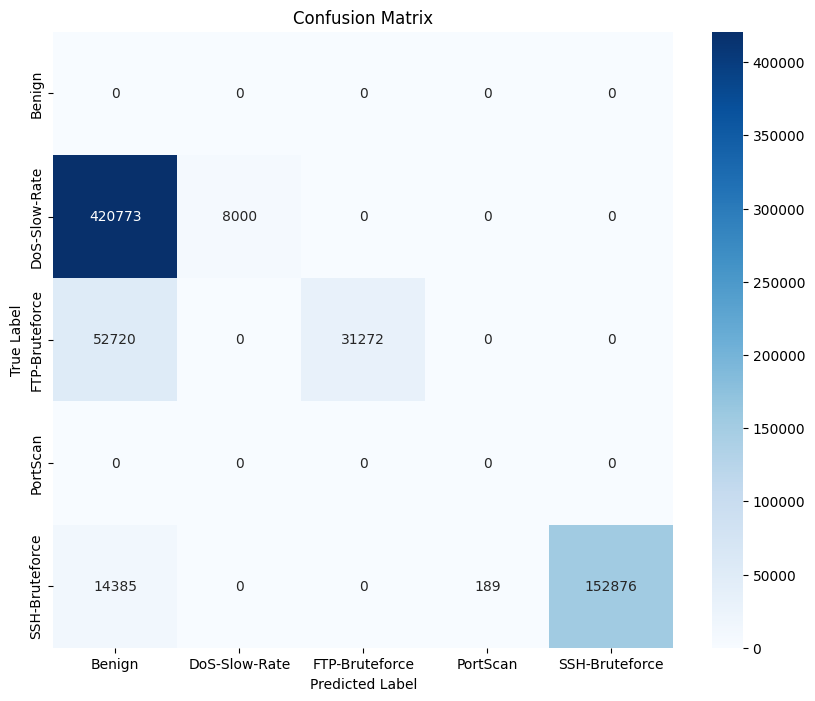

In [39]:
# prompt: do confusion matrix of the from sklearn.metrics import classification_report
# all_true_labels = []
# all_predicted_labels = []
# for attack in attacks:
#     pcap_files = os.listdir(f'/content/{attack}')
#     for pcap_file in pcap_files:
#         file_name = pcap_file.split('.')[0]
#         prediction_file_name = f'{file_name}_prediction.csv'
#         prediction_file_dir = f'/content/{attack}_prediction/'
#         prediction_csv_path = f'{prediction_file_dir}/{prediction_file_name}'
#         try:
#             df_prediction = pd.read_csv(prediction_csv_path)
#             # The true label for all packets in this file is the 'attack' name
#             if attack != 'DoS-SlowRate':
#                 true_label = attack
#             else:
#                 true_label = 'DoS-Slow-Rate'
#             # Collect the predicted label for each packet from 'Chosen_Label'
#             predicted_labels = df_prediction['Chosen_Label'].tolist()
#             # Extend our master lists
#             all_true_labels.extend([true_label] * len(predicted_labels))
#             all_predicted_labels.extend(predicted_labels)
#         except FileNotFoundError:
#             print(f"Prediction file not found for {pcap_file}: {prediction_csv_path}")
#         except Exception as e:
#             print(f"Error processing prediction file {prediction_csv_path}: {e}")
# # Now, print the classification report using the collected true and predicted labels
# if all_true_labels and all_predicted_labels:
#     print("\n--- Classification Report ---")
#     # Ensure both lists are of the same length
#     if len(all_true_labels) == len(all_predicted_labels):
#         print(classification_report(all_true_labels, all_predicted_labels, zero_division=0))
#     else:
#         print("Error: Mismatch in the number of true labels and predicted labels.")
# else:
#     print("\nNo data collected to generate a classification report.") too

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
# Ensure the unique labels are consistent across true and predicted lists
unique_labels = sorted(list(set(all_true_labels + all_predicted_labels)))

if all_true_labels and all_predicted_labels and len(all_true_labels) == len(all_predicted_labels):
    cm = confusion_matrix(all_true_labels, all_predicted_labels, labels=unique_labels)

    print("\n--- Confusion Matrix ---")
    print(cm)

    # Optional: Visualize the confusion matrix using seaborn and matplotlib
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("\nCannot generate Confusion Matrix: Mismatch in the number of true labels and predicted labels or no data collected.")


# archivae again

In [ ]:
# set up for mapping function

# --- Setup and Imports (Run this cell first in Colab) ---
# Install Scapy and Pandas (output redirected to avoid clutter)
!pip install scapy pandas numpy > /content/log.txt

# Import necessary libraries
from scapy.all import PcapReader, IP, TCP, UDP, ICMP
import pandas as pd
import numpy as np
import ipaddress
import time
from collections import defaultdict
import struct
import traceback # For detailed error logging

# Define constants based on CICFlowMeter's declaration
# These are in microseconds based on the provided Java code
FLOW_TIMEOUT = 120_000_000 # 120 seconds = 2 minutes
FLOW_ACTIVITY_TIMEOUT = 5_000_000 # 5 seconds

print("Environment setup complete. Libraries installed and imported.")

Environment setup complete. Libraries installed and imported.


In [ ]:
# --- Helper Classes (PacketInfo, SimulatedFlow, FlowAggregator) ---
# These classes encapsulate the core logic for packet and flow handling.
# They are defined globally so they can be reused.

class PacketInfo:
    def __init__(self, packet_index, timestamp_us, src_ip, dst_ip, src_port, dst_port, protocol, tcp_flags=0):
        self.packet_index = packet_index
        self.timestamp_us = timestamp_us # Timestamp in microseconds
        self.src_ip = src_ip
        self.dst_ip = dst_ip
        self.src_port = src_port
        self.dst_port = dst_port
        self.protocol = protocol # e.g., 6 for TCP, 17 for UDP, 1 for ICMP
        self.tcp_flags = tcp_flags

        self.src_ip_bytes = self._ip_to_bytes(src_ip)
        self.dst_ip_bytes = self._ip_to_bytes(dst_ip)

        self.flow_id = self.generate_flow_id()

    def _ip_to_bytes(self, ip_str):
        """Converts an IP address string to a byte array."""
        try:
            return bytes(ipaddress.ip_address(ip_str).packed)
        except ValueError:
            return b''

    def has_flag_fin(self):
        """Check if TCP FIN flag is set."""
        return (self.protocol == 6) and (self.tcp_flags & 0x01) # FIN flag is 0x01

    def generate_flow_id(self):
        """
        Replicates CICFlowMeter's generateFlowId logic based on 5-tuple.
        This ensures bidirectional flows have a canonical ID.
        """
        forward = True
        src_bytes = self.src_ip_bytes
        dst_bytes = self.dst_ip_bytes

        if src_bytes and dst_bytes and len(src_bytes) == len(dst_bytes):
            for i in range(len(src_bytes)):
                if src_bytes[i] != dst_bytes[i]:
                    if src_bytes[i] > dst_bytes[i]:
                        forward = False
                    break

        if forward:
            flow_id_str = f"{self.src_ip}-{self.dst_ip}-{self.src_port}-{self.dst_port}-{self.protocol}"
        else:
            flow_id_str = f"{self.dst_ip}-{self.src_ip}-{self.dst_port}-{self.src_port}-{self.protocol}"
        return flow_id_str

    def __repr__(self):
        return (f"PacketInfo(idx={self.packet_index}, ts={self.timestamp_us}, "
                f"flow_id='{self.flow_id}', proto={self.protocol}, "
                f"src={self.src_ip}:{self.src_port}, dst={self.dst_ip}:{self.dst_port})")

class SimulatedFlow:
    def __init__(self, first_packet: PacketInfo):
        self.flow_id_string = first_packet.flow_id
        self.flow_start_time_us = first_packet.timestamp_us
        self.flow_last_seen_us = first_packet.timestamp_us
        self.packet_indices = []

        self.initial_src_ip_bytes = first_packet.src_ip_bytes

        self.add_packet_index(first_packet.packet_index)

        self.start_active_time_us = first_packet.timestamp_us
        self.end_active_time_us = first_packet.timestamp_us

    def add_packet_index(self, packet_index: int):
        """Adds a packet index to the flow."""
        self.packet_indices.append(packet_index)

    def update_flow_timestamps(self, current_timestamp_us: int):
        """Updates the flow's overall last seen timestamp."""
        self.flow_last_seen_us = current_timestamp_us

    def update_active_idle_time(self, current_timestamp_us: int, threshold_us: int):
        """Simulates BasicFlow's updateActiveIdleTime for feature tracking."""
        if current_timestamp_us - self.end_active_time_us > threshold_us:
            self.start_active_time_us = current_timestamp_us
            self.end_active_time_us = current_timestamp_us
        else:
            self.end_active_time_us = current_timestamp_us

    def get_duration_us(self):
        """Calculates the total duration of the flow in microseconds."""
        return self.flow_last_seen_us - self.flow_start_time_us

    def __repr__(self):
        return (f"SimulatedFlow(id='{self.flow_id_string}', "
                f"start_ts={self.flow_start_time_us}, end_ts={self.flow_last_seen_us}, "
                f"packets={len(self.packet_indices)}, "
                f"indices={self.packet_indices[:5]}...{self.packet_indices[-5:] if len(self.packet_indices) > 5 else ''})")

class FlowAggregator:
    def __init__(self, flow_timeout_us, flow_activity_timeout_us):
        self.current_flows = {} # {flow_id_string: SimulatedFlow_object}
        self.finished_flows = {} # {flow_id_string: SimulatedFlow_object} (using flow_id_string as key for direct lookup)
        self.flow_timeout_us = flow_timeout_us
        self.flow_activity_timeout_us = flow_activity_timeout_us

    def add_packet(self, packet: PacketInfo):
        if not packet:
            return

        current_timestamp = packet.timestamp_us
        flow_id_string = packet.flow_id

        if flow_id_string in self.current_flows:
            flow = self.current_flows[flow_id_string]

            # --- CICFlowMeter's Flow Termination Logic ---
            if current_timestamp - flow.flow_start_time_us > self.flow_timeout_us:
                if len(flow.packet_indices) > 1:
                    self.finished_flows[flow_id_string] = flow
                del self.current_flows[flow_id_string]
                self.current_flows[flow_id_string] = SimulatedFlow(packet)

            elif packet.has_flag_fin():
                flow.add_packet_index(packet.packet_index)
                flow.update_flow_timestamps(current_timestamp)
                if len(flow.packet_indices) > 1:
                    self.finished_flows[flow_id_string] = flow
                del self.current_flows[flow_id_string]

            else:
                flow.update_active_idle_time(current_timestamp, self.flow_activity_timeout_us)
                flow.add_packet_index(packet.packet_index)
                flow.update_flow_timestamps(current_timestamp)

        else:
            self.current_flows[flow_id_string] = SimulatedFlow(packet)

    def finish_all_remaining_flows(self):
        """Moves all flows still in current_flows to finished_flows."""
        for flow_id_string, flow in list(self.current_flows.items()):
            if len(flow.packet_indices) > 1:
                self.finished_flows[flow_id_string] = flow
            del self.current_flows[flow_id_string]

    def get_simulated_flow_data(self):
        """
        Returns a dictionary mapping CICFlowMeter's Flow ID string to list of packet indices.
        """
        all_simulated_flows = {**self.finished_flows, **self.current_flows}

        mapping_dict = {}
        for flow_id_str, flow_obj in all_simulated_flows.items():
            if len(flow_obj.packet_indices) >= 1: # Only include flows with > 1 packet
                mapping_dict[flow_id_str] = flow_obj.packet_indices
        return mapping_dict



### **Main Function: `process_pcap_and_map_flows`**

def process_pcap_and_map_flows(attack: str, name: str) -> pd.DataFrame:
    """
    Processes a PCAP file, simulates CICFlowMeter's flow generation,
    and merges the resulting packet-to-flow mapping with an existing
    CICFlowMeter output CSV.

    Args:
        attack (str): The name of the attack directory (e.g., "FTPBruteforce").
        name (str): The base name of the PCAP and CICFlowMeter output files
                    (e.g., "ftpbrute-ubuntu").

    Returns:
        pd.DataFrame: The merged DataFrame with a 'Packet Indices Mapped' column,
                      or None if an error occurs.
    """
    # Construct file paths
    pcap_file_path = f"{attack}/{name}.pcap"
    cicflowmeter_output_path = f"/content/{attack}_csv/{name}_ISCX.csv"
    output_merged_csv_path = f"/content/{attack}_index/{name}_index.csv"

    print(f"\n--- Starting processing for {attack}/{name} ---")
    print(f"PCAP: {pcap_file_path}")
    print(f"CICFlowMeter Output: {cicflowmeter_output_path}")
    print(f"Merged Output: {output_merged_csv_path}")

    flow_aggregator = FlowAggregator(FLOW_TIMEOUT, FLOW_ACTIVITY_TIMEOUT)

    print(f"\nStarting PCAP processing: {pcap_file_path}")
    packet_count = 0
    try:
        for pkt in PcapReader(pcap_file_path):
            packet_count += 1

            src_ip = None
            dst_ip = None
            src_port = 0
            dst_port = 0
            protocol = None
            tcp_flags = 0

            if IP in pkt:
                src_ip = pkt[IP].src
                dst_ip = pkt[IP].dst
                protocol = pkt[IP].proto

                if TCP in pkt:
                    src_port = pkt[TCP].sport
                    dst_port = pkt[TCP].dport
                    tcp_flags = pkt[TCP].flags
                elif UDP in pkt:
                    src_port = pkt[UDP].sport
                    dst_port = pkt[UDP].dport
                elif ICMP in pkt:
                    pass

                timestamp_us = int(pkt.time * 1_000_000)

                if src_ip and dst_ip and protocol is not None:
                    p_info = PacketInfo(
                        packet_index=packet_count,
                        timestamp_us=timestamp_us,
                        src_ip=src_ip,
                        dst_ip=dst_ip,
                        src_port=src_port,
                        dst_port=dst_port,
                        protocol=protocol,
                        tcp_flags=tcp_flags
                    )
                    flow_aggregator.add_packet(p_info)

    except FileNotFoundError:
        print(f"Error: PCAP file not found at {pcap_file_path}.")
        return None
    except Exception as e:
        print(f"An error occurred during PCAP processing for {pcap_file_path}: {e}")
        print(f"Error occurred at packet_count: {packet_count}")
        print(traceback.format_exc())
        return None

    flow_aggregator.finish_all_remaining_flows()
    simulated_flow_data = flow_aggregator.get_simulated_flow_data()

    print(f"\nPCAP processing complete. Processed {packet_count} packets.")
    print(f"Simulated {len(simulated_flow_data)} flows with more than 1 packet.")

    print(f"\nLoading CICFlowMeter output from: {cicflowmeter_output_path}")
    try:
        cic_df = pd.read_csv(cicflowmeter_output_path)

        # Standardize the 'Flow ID' column name and type for merging
        if 'Flow ID' in cic_df.columns:
            cic_df.rename(columns={'Flow ID': 'Flow ID'}, inplace=True)
        elif 'FlowId' in cic_df.columns:
            cic_df.rename(columns={'FlowId': 'Flow ID'}, inplace=True)
        else:
            print("Error: 'Flow ID' or 'FlowId' column not found in CICFlowMeter CSV.")
            return None

        cic_df['Flow ID'] = cic_df['Flow ID'].astype(str)

        packet_indices_series = pd.Series(simulated_flow_data)

        cic_df['Packet Indices Mapped'] = cic_df['Flow ID'].apply(lambda x: packet_indices_series.get(x, []))
        # cic_df['Packet Indices Mapped'] = cic_df['Packet Indices Mapped'].apply(lambda x: f"[{','.join(map(str, x))}]")

        print("\nMerged DataFrame head (showing Flow ID, Packet Count, and Mapped Indices):")
        display_cols = ['Flow ID', 'Packet Indices Mapped']
        packet_count_col_name = None
        for col in [' Packet Count', 'Packet Count', 'Total Fwd Packets', 'Total Backward Packets', 'Total Packets']:
            if col in cic_df.columns:
                packet_count_col_name = col
                break

        if packet_count_col_name:
            display_cols.insert(1, packet_count_col_name)

        print(cic_df[display_cols].head())

        cic_df.to_csv(output_merged_csv_path, index=False)
        print(f"\nUpdated CICFlowMeter output with packet indices saved to: {output_merged_csv_path}")

        print("\n--- Verification ---")
        total_cic_flows = len(cic_df)
        mapped_flows_count = cic_df[cic_df['Packet Indices Mapped'] != '[]'].shape[0]
        unmapped_flows_count = total_cic_flows - mapped_flows_count

        print(f"Total flows in CICFlowMeter output: {total_cic_flows}")
        print(f"Flows successfully mapped to packet indices: {mapped_flows_count}")
        print(f"Flows in CICFlowMeter output that could NOT be mapped: {unmapped_flows_count}")

        if packet_count_col_name:
            print("\nSample of Unmapped Flows:")
            unmapped_df = cic_df[cic_df['Packet Indices Mapped'] == '[]']
            print(unmapped_df[['Flow ID', packet_count_col_name]].head())
        else:
            print("\nSkipping sample of unmapped flows as 'Packet Count' column was not found.")

        # make the cic_df only return the packet_indices mapped of that csv
        cic_df = cic_df['Packet Indices Mapped']
        return cic_df,packet_count

    except FileNotFoundError:
        print(f"Error: CICFlowMeter output CSV not found at {cicflowmeter_output_path}.")
        return None
    except ValueError as ve:
        print(f"Configuration Error: {ve}")
        return None
    except Exception as e:
        print(f"An error occurred during merging with CICFlowMeter output: {e}")
        print(traceback.format_exc())
        return None

In [ ]:
for attack in attacks:
  print('--------------------------------')
  print(f"Processing packet mapping for {attack}")
  print('--------------------------------')
  attack_flows = os.listdir(f'/content/{attack}')
  for attack_flow in attack_flows:
    # do something with attack_flows
    file_base_name = attack_flow[:-5]
    attack_folder = attack
    packet_indices,packet_count = process_pcap_and_map_flows(attack_folder, file_base_name)

    if packet_indices is not None:
        # start reformat
        attack_index_dir = f'/content/{attack}_index'
        attack_index_file = f'{file_base_name}_index.csv'
        if attack_index_file.endswith('.csv'): # Ensure we're only processing CSV files
            file_path = os.path.join(attack_index_dir, attack_index_file)
            # print(f"Processing {file_path}")

            try:
                # Read the CSV file
                df = pd.read_csv(file_path)

                '''
                if 'Packet Indices Mapped' in df.columns:
                    # Drop all columns except 'Packet Indices Mapping'
                    df_reformatted = df[['Packet Indices Mapped']]

                    # Save the modified DataFrame back to the same CSV file
                    df_reformatted.to_csv(file_path, index=False) # index=False prevents writing DataFrame index as a column
                    print(f"Successfully reformatted {attack_index_file}")
                else:
                    print(f"'{attack_index_file}' does not contain 'Packet Indices Mapped' column. Skipping.")
                '''

            except Exception as e:
                print(f"Error processing {attack_index_file}: {e}")
    else:
      print(f"packet_indices for {attack_flow} not found skipping...")

--------------------------------
Processing packet mapping for FTP-Bruteforce
--------------------------------

--- Starting processing for FTP-Bruteforce/bruteforce_ftp ---
PCAP: FTP-Bruteforce/bruteforce_ftp.pcap
CICFlowMeter Output: /content/FTP-Bruteforce_csv/bruteforce_ftp_ISCX.csv
Merged Output: /content/FTP-Bruteforce_index/bruteforce_ftp_index.csv

Starting PCAP processing: FTP-Bruteforce/bruteforce_ftp.pcap

PCAP processing complete. Processed 49739 packets.
Simulated 3087 flows with more than 1 packet.

Loading CICFlowMeter output from: /content/FTP-Bruteforce_csv/bruteforce_ftp_ISCX.csv

Merged DataFrame head (showing Flow ID, Packet Count, and Mapped Indices):
                                Flow ID Packet Indices Mapped
0  192.168.1.70-192.168.1.90-36908-21-6            [161, 164]
1  192.168.1.70-192.168.1.90-36922-21-6        [29333, 29334]
2  192.168.1.70-192.168.1.90-36914-21-6            [163, 166]
3  192.168.1.70-192.168.1.90-36930-21-6            [169, 171]
4  192.16

In [ ]:
# list filename_index.csv to have only indexcolumn
for attack in attacks:
  print('--------------------------------')
  print(f"Reformat {attack}_index")
  print('--------------------------------')
  attack_indexs = os.listdir(f'/content/{attack}_index')
  for attack_index in attack_indexs:
    print(attack_index)

--------------------------------
Reformat FTP-Bruteforce_index
--------------------------------
ftpbrute-kali_index.csv
.ipynb_checkpoints
bruteforce_ftp_index.csv
ftpbrute-ubuntu_index.csv


# predictions

In [ ]:
# define function for model loading
import joblib
def load_model(model_name):
  model_path = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/' + model_name
  model = joblib.load(model_path)
  return model

# model = load_model(model_name)
# print(model)

In [ ]:
# load model
model_name = 'RandomForest400IntPortCIC1718-2.pkl'
model = load_model(model_name)
print(model)
# attacks = model.classes_

RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)


In [ ]:
# define function for df preprocessing

import pandas as pd
import numpy as np
import ast

def map_port(port):
    if port == 21:
        return 1  # FTP
    elif port == 22:
        return 2  # SSH
    elif port == 53:
        return 3  # DNS
    elif port == 80:
        return 4  # HTTP
    elif port == 443:
        return 5  # HTTPS
    else:
        return 6  # Other

def preprocess_dataframe(df):
    original_indices = set(df.index)

    # replace space in columns name with underscore
    df.columns = df.columns.str.strip().str.replace(' ', '_')

    df["Packet_Indices_Mapped"] = df["Packet_Indices_Mapped"].apply(ast.literal_eval)

    # drop objects type columns
    columns_to_drop = [
        'Flow_ID','Src_IP','Dst_IP','Src_Port','Protocol','Timestamp','Label'
    ]

    df = df.drop(columns=columns_to_drop)

    # remove rows with missing and infinite values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.dropna()

    # map destination port to 1-6 numbers
    df['Dst_Port'] = df['Dst_Port'].apply(map_port)

    return df

# preprocess_dataframe(df)

In [ ]:
for attack in attacks:
  print('--------------------------------')
  print(f"Processing {attack}")
  print('--------------------------------')
  attack_csv_folder = f'/content/{attack}'
  attack_flows = os.listdir(attack_csv_folder)
  attack_files = [attack_flow[:-5] for attack_flow in attack_flows]
  for attack_file in attack_files:
    attack_flow = f'{attack_file}_ISCX.csv'
    attack_index = f'{attack_file}_index.csv'
    flow_dir= f'/content/{attack}_csv'
    index_dir = f'/content/{attack}_index'
    # print(f"{attack_file} , {attack_flow} , {attack_index}")
    # do something with these attack file

    df = pd.read_csv(f'{index_dir}/{attack_index}')
    df = preprocess_dataframe(df)

    df = df[df['Packet_Indices_Mapped'].notna()]  # Remove NaNs
    df = df[df['Packet_Indices_Mapped'].astype(str).str.strip() != "[]"]

    prediction = model.predict(df.drop('Packet_Indices_Mapped', axis=1))
    prediction_df = pd.DataFrame(prediction, columns=['Prediction'])

    prediction_df['Packet_Indices_Mapped'] = df['Packet_Indices_Mapped'].values
    print(prediction_df)

--------------------------------
Processing FTP-Bruteforce
--------------------------------
     Prediction Packet_Indices_Mapped
0        Benign            [161, 164]
1        Benign        [29333, 29334]
2        Benign            [163, 166]
3        Benign            [169, 171]
4        Benign            [170, 172]
...         ...                   ...
6912     Benign        [30005, 30006]
6913     Benign        [40102, 40103]
6914     Benign        [29349, 29352]
6915     Benign        [20999, 21000]
6916     Benign        [44922, 44928]

[6917 rows x 2 columns]
     Prediction Packet_Indices_Mapped
0        Benign            [263, 264]
1        Benign            [263, 264]
2        Benign  [278, 291, 315, 316]
3        Benign            [329, 330]
4        Benign            [347, 348]
...         ...                   ...
1436     Benign        [19098, 19099]
1437     Benign        [20300, 20301]
1438     Benign          [6042, 6043]
1439     Benign            [874, 875]
1440     

In [ ]:
import pandas as pd
import numpy as np
import ast # Import ast for literal_eval

# Initialize an empty list to store results
results = []

# Iterate through each row of the predictions_df
for index, row in prediction_df.iterrows():
    label = row['Prediction']
    packet_indices_list = row['Packet_Indices_Mapped']

    # Ensure packet_indices_list is treated as a list
    if isinstance(packet_indices_list, str):
        try:
            packet_indices_list = ast.literal_eval(packet_indices_list)
        except (ValueError, SyntaxError):
            packet_indices_list = []
    elif not isinstance(packet_indices_list, list):
         packet_indices_list = []

    # Create a list of dictionaries for this flow's packets
    if packet_indices_list:
        for packet_index in packet_indices_list:
            results.append({'Packet_Index': packet_index, 'Label': label})

# Create the DataFrame from the results list
classified_packets_df = pd.DataFrame(results)

# --- Remove duplicate packet indices ---
# Sort by Packet_Index to keep the first occurrence if duplicates exist
classified_packets_df = classified_packets_df.sort_values(by='Packet_Index').drop_duplicates(subset=['Packet_Index'], keep='first')
# --- End of modification ---


# Create a DataFrame with all packet indices from 1 to packet_count
all_packets_df = pd.DataFrame({'Packet_Index': range(1, packet_count + 1)})

# Merge the two DataFrames, keeping all packets from all_packets_df
merged_df = pd.merge(all_packets_df, classified_packets_df, on='Packet_Index', how='left')

# Fill the NaN values in 'Label' (which represent unclassified packets) with 'Benign'
merged_df['Label'] = merged_df['Label'].fillna('-')

# Sort by Packet Index for better readability (already sorted by merge, but good practice)
packet_label_df = merged_df.sort_values(by='Packet_Index').reset_index(drop=True)

print(f"\nDataFrame with packet index and predicted label (Total packets: {len(packet_label_df)}):")
# packet_label_df
print(packet_label_df[(packet_label_df['Label'] == 'FTP-Bruteforce')])
print(packet_label_df['Label'].value_counts())


DataFrame with packet index and predicted label (Total packets: 13910):
       Packet_Index           Label
576             577  FTP-Bruteforce
597             598  FTP-Bruteforce
607             608  FTP-Bruteforce
646             647  FTP-Bruteforce
647             648  FTP-Bruteforce
...             ...             ...
13860         13861  FTP-Bruteforce
13861         13862  FTP-Bruteforce
13875         13876  FTP-Bruteforce
13880         13881  FTP-Bruteforce
13888         13889  FTP-Bruteforce

[417 rows x 2 columns]
Label
-                 12968
Benign              525
FTP-Bruteforce      417
Name: count, dtype: int64


# archive for map

In [ ]:
# reformat filename_index.csv to have only indexcolumn
import os

for attack in attacks:
  print('--------------------------------')
  print(f"Reformat {attack}_index")
  print('--------------------------------')
  attack_index_files = os.listdir(f'/content/{attack}_index')
  for attack_index_file in attack_index_files:
    attack_index_dir = f'/content/{attack}_index'
    if attack_index_file.endswith('.csv'): # Ensure we're only processing CSV files
        file_path = os.path.join(attack_index_dir, attack_index_file)
        # print(f"Processing {file_path}")

        try:
            # Read the CSV file
            df = pd.read_csv(file_path)

            if 'Packet Indices Mapped' in df.columns:
                # Drop all columns except 'Packet Indices Mapping'
                df_reformatted = df[['Packet Indices Mapped']]

                # Save the modified DataFrame back to the same CSV file
                df_reformatted.to_csv(file_path, index=False) # index=False prevents writing DataFrame index as a column
                print(f"Successfully reformatted {attack_index_file}")
            else:
                print(f"'{attack_index_file}' does not contain 'Packet Indices Mapped' column. Skipping.")

        except Exception as e:
            print(f"Error processing {attack_index_file}: {e}")



--------------------------------
Reformat DoS_index
--------------------------------
--------------------------------
Reformat DDoS_index
--------------------------------
--------------------------------
Reformat PortScan_index
--------------------------------
--------------------------------
Reformat Benign_index
--------------------------------
--------------------------------
Reformat DoS-HTTP-Flood_index
--------------------------------
--------------------------------
Reformat DoS-SlowRate_index
--------------------------------
--------------------------------
Reformat Benign2_index
--------------------------------
--------------------------------
Reformat DoS-overall_index
--------------------------------
--------------------------------
Reformat DoS-Layer3and4_index
--------------------------------
--------------------------------
Reformat FTP-Bruteforce_index
--------------------------------
Successfully reformatted ftpbrute-ubuntu_index.csv
--------------------------------
Ref

# cicflowsetup again

In [ ]:
!sudo apt-get install libpcap-dev > /content/log.txt # install libpcap-dev
!wget https://codeberg.org/iortega/TCPDUMP_and_CICFlowMeter/archive/master:CICFlowMeters/CICFlowMeter-3.0.zip # download CICFlowMeter3.0.zip
!unzip CICFlowMeter-3.0.zip -d CICFlowMeter-3.0 # Extract CICFlowMeter3.0.zip

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
--2025-06-08 05:24:15--  https://codeberg.org/iortega/TCPDUMP_and_CICFlowMeter/archive/master:CICFlowMeters/CICFlowMeter-3.0.zip
Resolving codeberg.org (codeberg.org)... 217.197.84.140, 2a0a:4580:103f:c0de::1
Connecting to codeberg.org (codeberg.org)|217.197.84.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15039922 (14M) [application/octet-stream]
Saving to: ‘CICFlowMeter-3.0.zip’

CICFlowMeter-3.0.zi 100%[===================>]  14.34M  11.4MB/s    in 1.3s    

2025-06-08 05:24:17 (11.4 MB/s) - ‘CICFlowMeter-3.0.z

In [ ]:
!chmod +x ./CICFlowMeter-3.0/tcpdump_and_cicflowmeter/bin/CICFlowMeter

In [ ]:
import os

# Define the directory paths
in_directory = 'data/in'
out_directory = 'data/out'

# Create the directories if they don't exist
os.makedirs(in_directory, exist_ok=True)
os.makedirs(out_directory, exist_ok=True)

print(f"Directories '{in_directory}' and '{out_directory}' created (if they didn't exist).")

Directories 'data/in' and 'data/out' created (if they didn't exist).


# Convert each attack to iscx

In [ ]:
import shutil
import subprocess
import os

attacks = ['FTP-Bruteforce']

for attack in attacks:
  print('--------------------------------')
  print(f"Processing : {attack}")
  print('--------------------------------')
  attack_folder = f'/content/{attack}'
  attack_pcaps = os.listdir(attack_folder)
  for attack_pcap in attack_pcaps:
    # do something with each attack pcap
    print(f"Processing : {attack_pcap}")
    # convert file.pcap to flow
    # move pcap file to data/out
    data_in_folder = '/content/data/in'
    try:
      shutil.move(f'{attack_folder}/{attack_pcap}',data_in_folder)
      # run cicflowmeter
      cicflowmeter_command = './CICFlowMeter-3.0/tcpdump_and_cicflowmeter/bin/CICFlowMeter'
      subprocess.run([cicflowmeter_command], check=True, capture_output=True, text=True)
      print(f"Converted {attack_pcap} to flow")
      # create attack_flow folder
      flow_destination_directory = f'{attack}_flow'
      os.makedirs(flow_destination_directory, exist_ok=True)
      print(f"Directory '{flow_destination_directory}' created (if it didn't exist).")
      # move attack pcap from data/in back to attack_folder
      shutil.move(f'{data_in_folder}/{attack_pcap}',attack_folder)
      # move file_ISCX.csv to attack_flow folder
      data_out_folder = '/content/data/out'
      flow_file_name = attack_pcap[:-5] + '_ISCX.csv'
      shutil.move(f'{data_out_folder}/{flow_file_name}',flow_destination_directory)
      print(f"Moved {flow_file_name} to {flow_destination_directory}")
    except Exception as e:
      print(f"Error: {e}")

--------------------------------
Processing : FTP-Bruteforce
--------------------------------
Processing : bruteforce_ftp.pcap
Converted bruteforce_ftp.pcap to flow
Directory 'FTP-Bruteforce_flow' created (if it didn't exist).
Moved bruteforce_ftp_ISCX.csv to FTP-Bruteforce_flow
Processing : ftpbrute-ubuntu.pcap
Converted ftpbrute-ubuntu.pcap to flow
Directory 'FTP-Bruteforce_flow' created (if it didn't exist).
Moved ftpbrute-ubuntu_ISCX.csv to FTP-Bruteforce_flow
Processing : ftpbrute-kali.pcap
Converted ftpbrute-kali.pcap to flow
Directory 'FTP-Bruteforce_flow' created (if it didn't exist).
Moved ftpbrute-kali_ISCX.csv to FTP-Bruteforce_flow


# clean

In [ ]:
!rmdir /content/SSH-Bruteforce --ignore-fail-on-non-empty
!rmdir /content/FTP-Bruteforce --ignore-fail-on-non-empty

# CICFlowMeterSetup

In [ ]:
!sudo apt-get install libpcap-dev # install libpcap-dev
!wget https://codeberg.org/iortega/TCPDUMP_and_CICFlowMeter/archive/master:CICFlowMeters/CICFlowMeter-3.0.zip # download CICFlowMeter3.0.zip
!unzip CICFlowMeter-3.0.zip -d CICFlowMeter-3.0 # Extract CICFlowMeter3.0.zip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libdbus-1-dev libpcap0.8 libpcap0.8-dev
The following NEW packages will be installed:
  libdbus-1-dev libpcap-dev libpcap0.8 libpcap0.8-dev
0 upgraded, 4 newly installed, 0 to remove and 35 not upgraded.
Need to get 607 kB of archives.
After this operation, 2,238 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpcap0.8 amd64 1.10.1-4ubuntu1.22.04.1 [145 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdbus-1-dev amd64 1.12.20-2ubuntu4.1 [188 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpcap0.8-dev amd64 1.10.1-4ubuntu1.22.04.1 [270 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpcap-dev amd64 1.10.1-4ubuntu1.22.04.1 [3,326 B]
Fetched 607 kB in 1s (485 kB/s)
debconf: unable to initialize frontend: Dialog
deb

In [ ]:
import os

# Define the directory paths
in_directory = 'data/in'
out_directory = 'data/out'

# Create the directories if they don't exist
os.makedirs(in_directory, exist_ok=True)
os.makedirs(out_directory, exist_ok=True)

print(f"Directories '{in_directory}' and '{out_directory}' created (if they didn't exist).")

Directories 'data/in' and 'data/out' created (if they didn't exist).


# Setup attack_csv

In [ ]:
import os
import zipfile

def list_csv_files(attack):

  # list attack_csv.zip file
  attack = attack + '_csv'
  directory_path = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForbaseline_csv'

  if os.path.exists(directory_path):
    contents = os.listdir(directory_path)
    for item in contents:
      print(item)
  else:
    print(f"Directory not found: {directory_path}")


  print("\n-------------------------\n")
  # unzip attack_csv.zip file
  zip_file_path = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForbaseline_csv/' + attack + '.zip'
  destination_directory = '/content/'

  try:
      with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
          zip_ref.extractall(destination_directory)
      print(f"'{zip_file_path}' unzipped to '{destination_directory}'.")
  except FileNotFoundError:
      print(f"Error: Zip file not found at '{zip_file_path}'")
  except zipfile.BadZipFile:
      print(f"Error: '{zip_file_path}' is not a valid zip file.")
  except Exception as e:
      print(f"An error occurred: {e}")

  print("\n-------------------------\n")
  # list unzipped attack_csv files
  directory = attack
  csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

  if csv_files:
      print(f"Found {len(csv_files)} .csv files in '{directory}':")
      for csv_file in csv_files:
          print(csv_file)
  else:
      print(f"No .csv files found in '{directory}'.")

# list_csv_files(attack)

# Load model

In [ ]:
import joblib
def load_model(model_name):
  model_path = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/' + model_name
  model = joblib.load(model_path)
  return model

# model = load_model(model_name)
# print(model)

# Concat and Label same type csv and load as dataframe

In [ ]:
import pandas as pd
import os

def concat_csv(attack):
  # list unzipped attack_csv files
  attack_folder = attack + '_csv'
  directory = attack_folder
  csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

  all_csv_data = []

  # add attack to label and concat csvs
  if csv_files:
      print(f"Found {len(csv_files)} .csv files in '{directory}':")
      for csv_file in csv_files:
          print(csv_file)
          file_path = os.path.join(directory, csv_file)
          try:
              df = pd.read_csv(file_path)
              df['Label'] = attack
              all_csv_data.append(df)
          except Exception as e:
              print(f"Error reading {csv_file}: {e}")

      print("\n-------------------------\n")
      if all_csv_data:
          concatenated_df = pd.concat(all_csv_data, ignore_index=True)
          print("All CSV files concatenated into a single DataFrame.")
          return concatenated_df
      else:
          print("No data read from CSV files.")
          return pd.DataFrame()
  else:
      print(f"No .csv files found in '{directory}'.")
      return pd.DataFrame()

# Pre process dataframe

In [ ]:
import pandas as pd
import numpy as np

def map_port(port):
    if port == 21:
        return 1  # FTP
    elif port == 22:
        return 2  # SSH
    elif port == 53:
        return 3  # DNS
    elif port == 80:
        return 4  # HTTP
    elif port == 443:
        return 5  # HTTPS
    else:
        return 6  # Other

def preprocess_dataframe(df):
    # replace space in columns name with underscore
    df.columns = df.columns.str.strip().str.replace(' ', '_')

    # drop objects type columns
    columns_to_drop = [
        'Flow_ID','Src_IP','Dst_IP','Src_Port','Protocol','Timestamp'
    ]

    df = df.drop(columns=columns_to_drop)

    # remove rows with missing and infinite values
    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    df = df.dropna()

    # map destination port to 1-6 numbers
    df['Dst_Port'] = df['Dst_Port'].apply(map_port)

    return df

# preprocess_dataframe(df)

# Make Prediction

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd # Import pandas to display confusion matrix nicely
from IPython.display import display # Import display

def make_prediction(model, df):
  # Split the dataframe into features (X) and labels (y)
  X = df.drop('Label', axis=1)
  y = df['Label']

  # Make predictions
  predictions = model.predict(X)

  # Calculate and print the classification report
  print(classification_report(y, predictions))

  # Calculate and print the confusion matrix
  cm = confusion_matrix(y, predictions, labels=model.classes_)
  cm_df = pd.DataFrame(cm, index=model.classes_, columns=model.classes_)
  print("\nConfusion Matrix:")
  display(cm_df) # Use display() instead of print()

# make_prediction(model, df)

# Main

In [ ]:
attack = 'SSH-Bruteforce'
model_name = 'RandomForest400IntPortCIC1718-2.pkl'

model = load_model(model_name)
attacks = model.classes_

for attack in attacks:
  list_csv_files(attack)
  df = concat_csv(attack)
  df = preprocess_dataframe(df)
  print(f"Prediction of {attack}")
  make_prediction(model, df)

DoS_csv.zip
DDoS_csv.zip
PortScan_csv.zip
Benign_csv.zip
DoS-HTTP-Flood_csv.zip
DoS-Layer3and4_csv.zip
DoS-overall_csv.zip
FTP-Bruteforce_csv.zip
SSH-Bruteforce_csv.zip
DoS-Slow-Rate_csv.zip

-------------------------

'/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForbaseline_csv/Benign_csv.zip' unzipped to '/content/'.

-------------------------

Found 21 .csv files in 'Benign_csv':
normal_10_ISCX.csv
Normal-h3_11_ISCX.csv
DoS-Hulk_benign_ISCX.csv
Normal-h3_6_ISCX.csv
normal_12_ISCX.csv
Normal-h3_2_ISCX.csv
Normal-h3_10_ISCX.csv
normal_3_ISCX.csv
normal_2_ISCX.csv
Normal-h3_1_ISCX.csv
Normal-h3_5_ISCX.csv
normal_11_ISCX.csv
Normal-h3_4_ISCX.csv
Normal-h3_3_ISCX.csv
Normal-h3_8_ISCX.csv
normal_4_ISCX.csv
normal_13_ISCX.csv
Normal-h3_12_ISCX.csv
Normal-h3_9_ISCX.csv
DoS-GoldenEye_benign_ISCX.csv
normal_1_ISCX.csv
Found 21 .csv files in 'Benign_csv':
normal_10_ISCX.csv
Normal-h3_11_ISCX.csv
DoS-Hulk_benign_ISCX.csv
Normal-h3_6_ISCX.csv
normal_12_ISCX.csv
Normal-h3_2_ISCX.cs

,Benign,DoS-HTTP-Flood,DoS-Slow-Rate,FTP-Bruteforce,PortScan,SSH-Bruteforce
Benign,58684,0,1,0,0,1
DoS-HTTP-Flood,0,0,0,0,0,0
DoS-Slow-Rate,0,0,0,0,0,0
FTP-Bruteforce,0,0,0,0,0,0
PortScan,0,0,0,0,0,0
SSH-Bruteforce,0,0,0,0,0,0


DoS_csv.zip
DDoS_csv.zip
PortScan_csv.zip
Benign_csv.zip
DoS-HTTP-Flood_csv.zip
DoS-Layer3and4_csv.zip
DoS-overall_csv.zip
FTP-Bruteforce_csv.zip
SSH-Bruteforce_csv.zip
DoS-Slow-Rate_csv.zip

-------------------------

'/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForbaseline_csv/DoS-HTTP-Flood_csv.zip' unzipped to '/content/'.

-------------------------

Found 6 .csv files in 'DoS-HTTP-Flood_csv':
DoS-Hulk_attack_ISCX.csv
DoS-GoldenEye_attack_ISCX.csv
GoldenEye_ISCX.csv
hulk_ISCX.csv
DDoS HTTP Flood Attacks_ISCX.csv
http_dos_ISCX.csv
Found 6 .csv files in 'DoS-HTTP-Flood_csv':
DoS-Hulk_attack_ISCX.csv
DoS-GoldenEye_attack_ISCX.csv
GoldenEye_ISCX.csv
hulk_ISCX.csv
DDoS HTTP Flood Attacks_ISCX.csv
http_dos_ISCX.csv

-------------------------

All CSV files concatenated into a single DataFrame.
Prediction of DoS-HTTP-Flood
                precision    recall  f1-score   support

        Benign       0.00      0.00      0.00         0
DoS-HTTP-Flood       1.00      0.04     

,Benign,DoS-HTTP-Flood,DoS-Slow-Rate,FTP-Bruteforce,PortScan,SSH-Bruteforce
Benign,0,0,0,0,0,0
DoS-HTTP-Flood,179010,7019,8642,0,0,0
DoS-Slow-Rate,0,0,0,0,0,0
FTP-Bruteforce,0,0,0,0,0,0
PortScan,0,0,0,0,0,0
SSH-Bruteforce,0,0,0,0,0,0


DoS_csv.zip
DDoS_csv.zip
PortScan_csv.zip
Benign_csv.zip
DoS-HTTP-Flood_csv.zip
DoS-Layer3and4_csv.zip
DoS-overall_csv.zip
FTP-Bruteforce_csv.zip
SSH-Bruteforce_csv.zip
DoS-Slow-Rate_csv.zip

-------------------------

'/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForbaseline_csv/DoS-Slow-Rate_csv.zip' unzipped to '/content/'.

-------------------------

Found 4 .csv files in 'DoS-Slow-Rate_csv':
slowread_1_ISCX.csv
slowread_2_ISCX.csv
lowrateddosMQTT_ISCX.csv
http_slowloris_ISCX.csv
Found 4 .csv files in 'DoS-Slow-Rate_csv':
slowread_1_ISCX.csv
slowread_2_ISCX.csv
lowrateddosMQTT_ISCX.csv
http_slowloris_ISCX.csv

-------------------------

All CSV files concatenated into a single DataFrame.
Prediction of DoS-Slow-Rate
               precision    recall  f1-score   support

       Benign       0.00      0.00      0.00         0
DoS-Slow-Rate       1.00      0.02      0.04     51652

     accuracy                           0.02     51652
    macro avg       0.50      0.01 

,Benign,DoS-HTTP-Flood,DoS-Slow-Rate,FTP-Bruteforce,PortScan,SSH-Bruteforce
Benign,0,0,0,0,0,0
DoS-HTTP-Flood,0,0,0,0,0,0
DoS-Slow-Rate,50652,0,1000,0,0,0
FTP-Bruteforce,0,0,0,0,0,0
PortScan,0,0,0,0,0,0
SSH-Bruteforce,0,0,0,0,0,0


DoS_csv.zip
DDoS_csv.zip
PortScan_csv.zip
Benign_csv.zip
DoS-HTTP-Flood_csv.zip
DoS-Layer3and4_csv.zip
DoS-overall_csv.zip
FTP-Bruteforce_csv.zip
SSH-Bruteforce_csv.zip
DoS-Slow-Rate_csv.zip

-------------------------

'/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForbaseline_csv/FTP-Bruteforce_csv.zip' unzipped to '/content/'.

-------------------------

Found 3 .csv files in 'FTP-Bruteforce_csv':
ftpbrute-kali_ISCX.csv
ftpbrute-ubuntu_ISCX.csv
bruteforce_ftp_ISCX.csv
Found 3 .csv files in 'FTP-Bruteforce_csv':
ftpbrute-kali_ISCX.csv
ftpbrute-ubuntu_ISCX.csv
bruteforce_ftp_ISCX.csv

-------------------------

All CSV files concatenated into a single DataFrame.
Prediction of FTP-Bruteforce
                precision    recall  f1-score   support

        Benign       0.00      0.00      0.00         0
FTP-Bruteforce       1.00      0.10      0.18      9400

      accuracy                           0.10      9400
     macro avg       0.50      0.05      0.09      9400
  wei

,Benign,DoS-HTTP-Flood,DoS-Slow-Rate,FTP-Bruteforce,PortScan,SSH-Bruteforce
Benign,0,0,0,0,0,0
DoS-HTTP-Flood,0,0,0,0,0,0
DoS-Slow-Rate,0,0,0,0,0,0
FTP-Bruteforce,8497,0,0,903,0,0
PortScan,0,0,0,0,0,0
SSH-Bruteforce,0,0,0,0,0,0


DoS_csv.zip
DDoS_csv.zip
PortScan_csv.zip
Benign_csv.zip
DoS-HTTP-Flood_csv.zip
DoS-Layer3and4_csv.zip
DoS-overall_csv.zip
FTP-Bruteforce_csv.zip
SSH-Bruteforce_csv.zip
DoS-Slow-Rate_csv.zip

-------------------------

'/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForbaseline_csv/PortScan_csv.zip' unzipped to '/content/'.

-------------------------

Found 10 .csv files in 'PortScan_csv':
nmap_fin_ISCX.csv
normal_scanning4_ISCX.csv
normal_scanning6_ISCX.csv
normal_scanning3_ISCX.csv
nmap_null_ISCX.csv
normal_scanning1_ISCX.csv
portscan_ISCX.csv
Port Scanning attack_ISCX.csv
normal_scanning5_ISCX.csv
normal_scanning2_ISCX.csv
Found 10 .csv files in 'PortScan_csv':
nmap_fin_ISCX.csv
normal_scanning4_ISCX.csv
normal_scanning6_ISCX.csv
normal_scanning3_ISCX.csv
nmap_null_ISCX.csv
normal_scanning1_ISCX.csv
portscan_ISCX.csv
Port Scanning attack_ISCX.csv
normal_scanning5_ISCX.csv
normal_scanning2_ISCX.csv

-------------------------

All CSV files concatenated into a single DataF

,Benign,DoS-HTTP-Flood,DoS-Slow-Rate,FTP-Bruteforce,PortScan,SSH-Bruteforce
Benign,0,0,0,0,0,0
DoS-HTTP-Flood,0,0,0,0,0,0
DoS-Slow-Rate,0,0,0,0,0,0
FTP-Bruteforce,0,0,0,0,0,0
PortScan,146127,0,0,0,0,0
SSH-Bruteforce,0,0,0,0,0,0


DoS_csv.zip
DDoS_csv.zip
PortScan_csv.zip
Benign_csv.zip
DoS-HTTP-Flood_csv.zip
DoS-Layer3and4_csv.zip
DoS-overall_csv.zip
FTP-Bruteforce_csv.zip
SSH-Bruteforce_csv.zip
DoS-Slow-Rate_csv.zip

-------------------------

'/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForbaseline_csv/SSH-Bruteforce_csv.zip' unzipped to '/content/'.

-------------------------

Found 3 .csv files in 'SSH-Bruteforce_csv':
bruteforce_ssh_ISCX.csv
sshbrute-kali_ISCX.csv
sshbrute-ubuntu_ISCX.csv
Found 3 .csv files in 'SSH-Bruteforce_csv':
bruteforce_ssh_ISCX.csv
sshbrute-kali_ISCX.csv
sshbrute-ubuntu_ISCX.csv

-------------------------

All CSV files concatenated into a single DataFrame.
Prediction of SSH-Bruteforce
                precision    recall  f1-score   support

        Benign       0.00      0.00      0.00         0
DoS-HTTP-Flood       0.00      0.00      0.00         0
      PortScan       0.00      0.00      0.00         0
SSH-Bruteforce       1.00      0.42      0.60      7225

     

,Benign,DoS-HTTP-Flood,DoS-Slow-Rate,FTP-Bruteforce,PortScan,SSH-Bruteforce
Benign,0,0,0,0,0,0
DoS-HTTP-Flood,0,0,0,0,0,0
DoS-Slow-Rate,0,0,0,0,0,0
FTP-Bruteforce,0,0,0,0,0,0
PortScan,0,0,0,0,0,0
SSH-Bruteforce,4137,2,0,0,16,3070
